# APPeal: Classificazione

## Import librerie e inizializzazione dello Spark Context

In [1]:
from pyspark.ml import Pipeline

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.mllib.tree import DecisionTree as DT
from pyspark.mllib.tree import DecisionTreeModel, LabeledPoint

from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql import Row

from pyspark.sql.types import IntegerType

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn import neighbors

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

spark = SparkSession.builder.getOrCreate()

In [2]:
data = spark.read.option("header",True).option('inferSchema', True).json("no_outlier_KMeans_v3.json")

In [3]:
data.printSchema()

root
 |-- AdSupported: boolean (nullable = true)
 |-- Age: long (nullable = true)
 |-- AppId: string (nullable = true)
 |-- AppName: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- DeveloperId: string (nullable = true)
 |-- EditorsChoice: boolean (nullable = true)
 |-- InApp: boolean (nullable = true)
 |-- Installs: double (nullable = true)
 |-- Installs_stdev_from_Category: double (nullable = true)
 |-- MinAndroid: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- Price_stdev_from_Category: double (nullable = true)
 |-- Quarter_of_Release: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Rating_Reviews_Ratio: double (nullable = true)
 |-- Rating_stdev_from_Category: double (nullable = true)
 |-- Reviews_Installs_Ratio: double (nullable = true)
 |-- Size: double (nullable = true)
 |-- Size_stdev_from_Category: double (nullable = true)
 |-- Year_of_Last_Update: long (nullable = true)
 |-- Year_of_Release: long (nullable = true)
 

### definizione funzioni

In [4]:
def getAppeal(value):
    """
    Defines target variable
    """
    if float(value) >= 3.5:
        return 1
    else:
        return 0

def save_clf(clf, version, directory='models'):
    """
    Saves classifier to models directory
    """
    if not os.path.isdir(directory):
        os.mkdir(directory)
        print(f"Directory {directory} created")
    
    filename = f'{directory}/{str(type(clf)).split(".")[-1][:-2]}-{version}.model'

    if not os.path.isfile(filename):
        clf.save(filename)
        print('Model saved:', filename)
    else:
        print('File already exists:', filename)
        
def load_clf(base, filename, directory='models'):
    """
    Loads MLib clfier
    """
    file = os.path.join(directory, filename)

    clf = base.load(file)
    print('Model loaded:', filename)
    return clf

def grid_search(train, model, paramGrid):
    crossval = CrossValidator(estimator=model,
                      estimatorParamMaps=paramGrid,
                      evaluator=BinaryClassificationEvaluator().setLabelCol("Appeal"),
                      numFolds=5)  # imposto a 5 per la 5-fold cv
    fit_model = crossval.fit(train)
    print(fit_model)
    bestModel = fit_model.bestModel
    return bestModel

def get_params(model, params):
    """
    Prints model parameters
    """
    extract_par = model.extractParamMap()
    best_parameters = {}
    for par in params:
        if model.hasParam(par):
            best_parameters[par] = extract_par[model.getParam(par)]
    print(best_parameters)

def scale_data(data):
    scaler = MinMaxScaler(inputCol='features_classification',outputCol='features_standardized')
    scaled = scaler.fit(data).transform(data)
    return scaled

def my_confusion_matrix(cfm):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

def evaluate(predictions):
    """
    Prints evaluation metrics
    Plots confusion matrix
    """
 
    evaluator = BinaryClassificationEvaluator(labelCol="Appeal")
    AUC  = evaluator.evaluate(predictions)
    
    cm = predictions.crosstab("prediction", "Appeal").toPandas()
    
    # calculate 
    TP = cm["1"][0]
    FP = cm["0"][0]
    TN = cm["0"][1]
    FN = cm["1"][1]
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    Recall = TP/(TP+FN)
    Specificity = TN/(TN+FP)
    Precision = TP/(TP+FP)
    F1 = 2 * ((Precision * Recall)/(Precision + Recall))
    print("Model Performance Measure")
    print ("Accuracy = %0.2f" %Accuracy )
    print ("Specificity = %0.2f" %Specificity )
    print ("Precision = %0.2f" %Precision )
    print ("Recall = %0.2f" %Recall )
    print ("F1-score = %0.2f" %F1 )
    
    print("AUC = %.2f" % AUC)
    
    my_confusion_matrix(np.array([[TN, FP],[ FN, TP]]))

from sklearn.metrics import roc_curve, auc

def plot_ROC(predictions):
    PredAndLabels           = predictions.select("probability", "Appeal")
    PredAndLabels_collect   = PredAndLabels.collect()
    PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
    PredAndLabels           = sc.parallelize(PredAndLabels_list)

    metrics = BinaryClassificationMetrics(PredAndLabels)

    # Area under ROC
    print("Area under ROC = %.2f" % metrics.areaUnderROC)

    # Visualization
    FPR = dict()                                                        # FPR: False Positive Rate
    tpr = dict()                                                        # TPR: True Positive Rate
    roc_auc = dict()

    y_test = [i[1] for i in PredAndLabels_list]
    y_score = [i[0] for i in PredAndLabels_list]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### Preprocessing: binarizzazione di rating ed eliminazione features rimaste dal clustering

In [5]:
data = data.withColumn("Appeal", udf(getAppeal)("Rating"))

In [6]:
data = data.withColumn("Quarter_of_Release", data["Quarter_of_Release"].cast(IntegerType()))
data = data.withColumn("Appeal", data["Appeal"].cast(IntegerType()))

In [7]:
data = data.drop("Rating","prediction", "features_cluster", "distances", "standardized", "position")

### Assembling

In [8]:
features_classification = ["Age","EditorsChoice",
                           "AdSupported","InApp", "Price",
                           "Year_of_Release","Quarter_of_Release",
                           "Price_stdev_from_Category", "Year_of_Last_Update"]

#,
                          #"Installs_stdev_from_Category"] #, "Installs"]
    

In [9]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features_classification, outputCol='features_classification')

data = assembler.transform(data)

In [10]:
#data.select('features_classification').show(10)

## Classification Pipeline

### Train-test split

In [11]:
# trasformo la colonna della target variable -> recupero l'indice                                       
train, test = data.randomSplit([0.7, 0.3], seed=0)

In [12]:
train.select('AppName', 'features_classification', 'Appeal').show(5)

+---------------------------------+-----------------------+------+
|                          AppName|features_classification|Appeal|
+---------------------------------+-----------------------+------+
|당뇨모리 (당뇨병환자를 위한 차...|   (9,[5,6,7,8],[201...|     0|
|                  A-1 Towing Inc.|   (9,[5,6,7,8],[201...|     0|
|             ThermoAnalytics U...|   (9,[5,6,7,8],[201...|     0|
|             2021 Pool and Spa...|   (9,[5,6,7,8],[202...|     0|
|             2021 AGA-Tallahas...|   (9,[5,6,7,8],[202...|     0|
+---------------------------------+-----------------------+------+
only showing top 5 rows



### Hyperparameter tuning

In [13]:
# set the model
model = RandomForestClassifier(labelCol="Appeal", featuresCol="features_classification", numTrees=300)

# set parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(model.impurity, ["entropy", "gini"])\
    .addGrid(model.maxDepth, [2, 5, 10])\
    .addGrid(model.maxBins, [2, 5, 10])\
    .build()
    

In [14]:
%%time
bestModel = grid_search(train, model, paramGrid)

CrossValidatorModel_4332bd5ef473
CPU times: user 3.74 s, sys: 1.55 s, total: 5.3 s
Wall time: 7h 20min 2s


In [15]:
bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_e32436007b77, numTrees=300, numClasses=2, numFeatures=9

In [21]:
params = ['impurity', 'maxDepth', 'maxBins']
get_params(bestModel, params)

{'impurity': 'gini', 'maxDepth': 5, 'maxBins': 15}


In [13]:
bestModel = RandomForestClassifier(labelCol="Appeal", featuresCol="features_classification", 
                                   impurity='gini', maxDepth=5, maxBins=15)\
            .fit(train)

In [42]:
save_clf(bestModel, 0)

Model saved: models/RandomForestClassificationModel-0.model


### Evaluation

In [14]:
predictions = bestModel.transform(test)

In [15]:
for i in range(len(features_classification)):
    print (i, features_classification[i])

0 Age
1 EditorsChoice
2 AdSupported
3 InApp
4 Price
5 Year_of_Release
6 Quarter_of_Release
7 Price_stdev_from_Category
8 Year_of_Last_Update


In [16]:
def extractFeatureImportance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

extractFeatureImportance(bestModel.featureImportances, test, 'features_classification')

,idx,name,score
5,5,Year_of_Release,0.437712
2,2,AdSupported,0.296788
3,3,InApp,0.170577
8,8,Year_of_Last_Update,0.063676
7,7,Price_stdev_from_Category,0.025511
4,4,Price,0.002819
0,0,Age,0.002283
6,6,Quarter_of_Release,0.000571
1,1,EditorsChoice,0.000063


Model Performance Measure
Accuracy = 0.64
Specificity = 0.81
Precision = 0.65
Recall = 0.43
F1-score = 0.51
AUC = 0.68


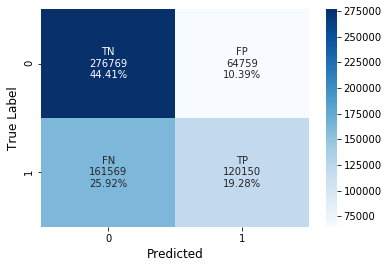

In [45]:
evaluate(predictions)

Area under ROC = 0.68


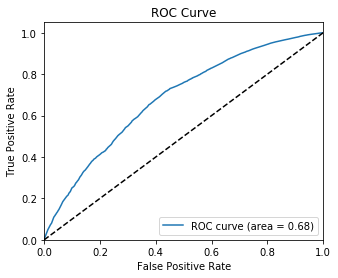

In [46]:
plot_ROC(predictions)

In [47]:
data[data['Appeal'] == 1].groupBy('AdSupported').count().show()

+-----------+------+
|AdSupported| count|
+-----------+------+
|       true|556556|
|      false|382333|
+-----------+------+



In [ ]:
data[data['Appeal'] == 1].groupBy('AdSupported').count().show()